<a href="https://colab.research.google.com/github/faizalram/QuantProject/blob/main/Simple_Pairs_Trading_Algo_(BBCA_vs_BBNI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Define the stock symbols
symbols = ['BBCA.JK', 'BBNI.JK']

# Fetch data
data = yf.download(symbols, start='2020-01-01', end='2024-01-01')['Adj Close']
data.dropna(inplace=True)  # Drop any rows with NaN values
data.head()  # Display the first few rows of data


[*********************100%***********************]  2 of 2 completed


Ticker,BBCA.JK,BBNI.JK
Date,,
2020-01-02 00:00:00+00:00,6029.958008,3363.986816
2020-01-03 00:00:00+00:00,6129.105469,3374.803711
2020-01-06 00:00:00+00:00,6070.517578,3299.086914
2020-01-07 00:00:00+00:00,6075.024902,3266.636963
2020-01-08 00:00:00+00:00,6020.944824,3212.553467


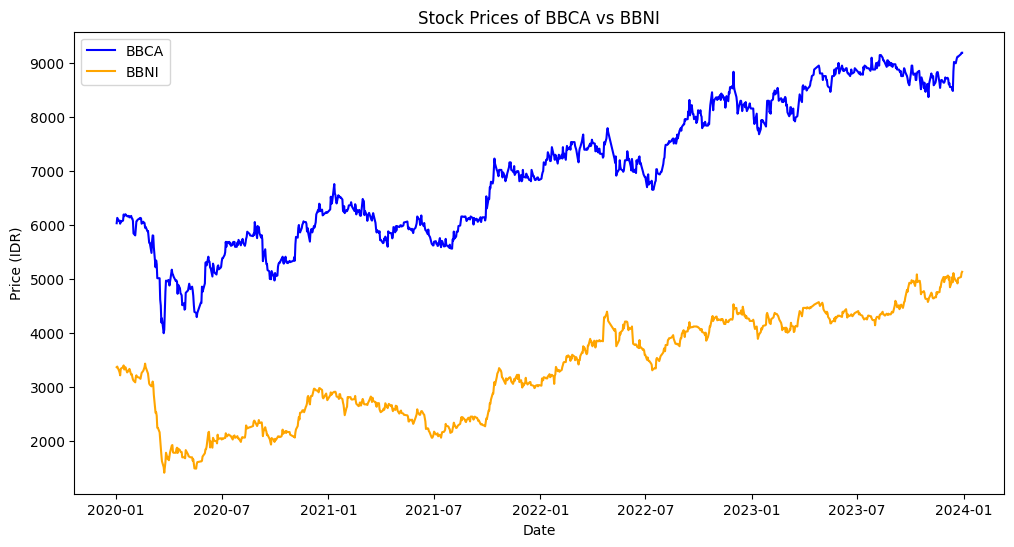

In [ ]:
# Plotting the prices
plt.figure(figsize=(12, 6))
plt.plot(data['BBCA.JK'], label='BBCA', color='blue')
plt.plot(data['BBNI.JK'], label='BBNI', color='orange')
plt.title('Stock Prices of BBCA vs BBNI')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.show()


In [ ]:
# Define a function for the cointegration test
def cointegration_test(stock1, stock2):
    score, p_value, _ = sm.tsa.coint(stock1, stock2)
    return p_value

# Perform the cointegration test
p_value = cointegration_test(data['BBCA.JK'], data['BBNI.JK'])
print(f'Cointegration test p-value for BBCA and BBNI: {p_value}')



Cointegration test p-value for BBCA and BBNI: 0.03171665362462701


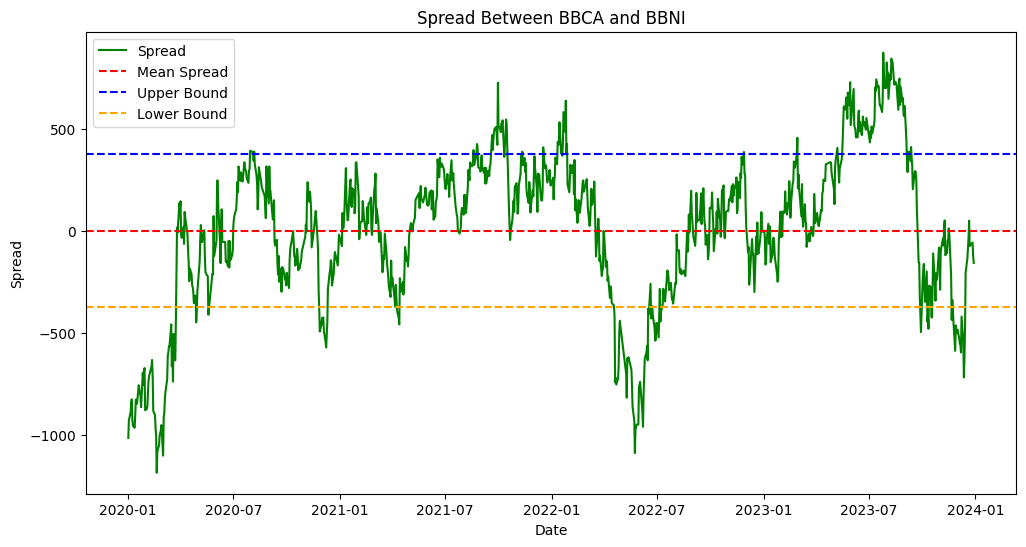

In [ ]:
# Calculate the spread
model = sm.OLS(data['BBCA.JK'], sm.add_constant(data['BBNI.JK'])).fit()
data['Spread'] = data['BBCA.JK'] - model.predict(sm.add_constant(data['BBNI.JK']))

# Plot the spread
plt.figure(figsize=(12, 6))
plt.plot(data['Spread'], label='Spread', color='green')
plt.axhline(data['Spread'].mean(), linestyle='--', color='red', label='Mean Spread')
plt.axhline(data['Spread'].mean() + data['Spread'].std(), linestyle='--', color='blue', label='Upper Bound')
plt.axhline(data['Spread'].mean() - data['Spread'].std(), linestyle='--', color='orange', label='Lower Bound')
plt.title('Spread Between BBCA and BBNI')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()


<ipython-input-89-ad182c15fe3d>:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Signal'][data['Spread'] > data['Spread'].mean() + entry_threshold * data['Spread'].std()] = -1  # Short
<ipython-input-89-ad182c15fe3d>:10: SettingWithCo

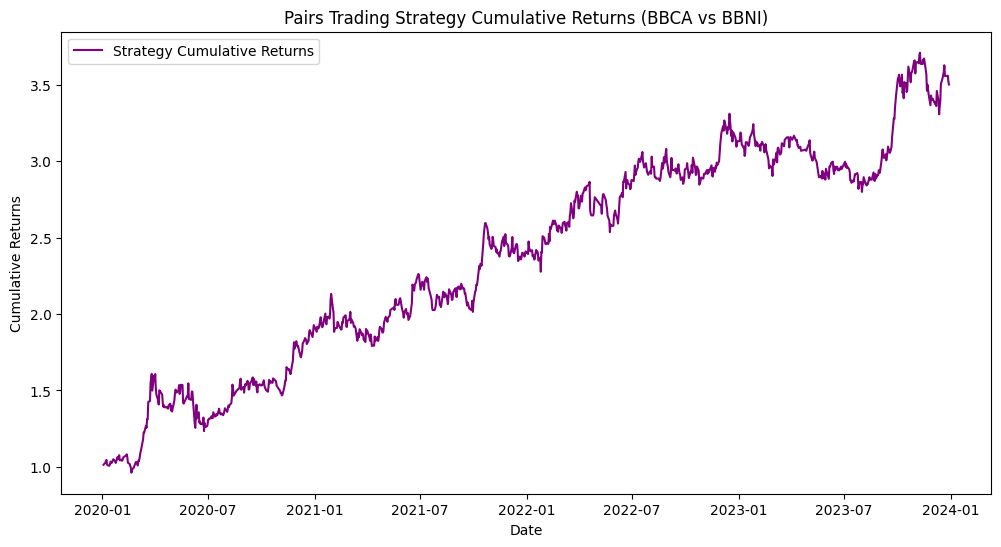

In [ ]:
# Generate signals based on the spread
entry_threshold = 1  # 1 standard deviation
exit_threshold = 0.5  # 0.5 standard deviation

# Initialize signals and positions
data['Signal'] = 0  # Default signal
data['Position'] = 0  # Default position


data['Signal'][data['Spread'] > data['Spread'].mean() + entry_threshold * data['Spread'].std()] = -1  # Short
data['Signal'][data['Spread'] < data['Spread'].mean() - entry_threshold * data['Spread'].std()] = 1  # Long
data['Position'] = data['Signal'].replace(to_replace=0, method='ffill')  # Forward fill signals

# Calculate daily returns
data['BBCA_Return'] = data['BBCA.JK'].pct_change()
data['BBNI_Return'] = data['BBNI.JK'].pct_change()

# Calculate strategy returns
data['Strategy_Return'] = data['Position'].shift(1) * (data['BBCA_Return'] - data['BBNI_Return'])

# Cumulative returns
data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Return']).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Strategy_Returns'], label='Strategy Cumulative Returns', color='purple')
plt.title('Pairs Trading Strategy Cumulative Returns (BBCA vs BBNI)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


In [ ]:
# Performance metrics
cumulative_return = data['Cumulative_Strategy_Returns'][-1] - 1
sharpe_ratio = data['Strategy_Return'].mean() / data['Strategy_Return'].std() * np.sqrt(252)  # Annualized Sharpe Ratio

print(f'Cumulative Return: {cumulative_return:.2%}')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')


Cumulative Return: 250.31%
Sharpe Ratio: 1.23


<ipython-input-90-0608a8f8962d>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = data['Cumulative_Strategy_Returns'][-1] - 1


[*********************100%***********************]  2 of 2 completed
<ipython-input-91-c85055708d2e>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Spread'] = train_data['BBCA.JK'] - model.predict(sm.add_constant(train_data['BBNI.JK']))
<ipython-input-91-c85055708d2e>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Signal'] = 0  # Default signal
<ipython-input-91-c85055708d2e>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Ticker                         BBCA.JK      BBNI.JK
Date                                               
2020-01-02 00:00:00+00:00  6029.958008  3363.986816
2020-01-03 00:00:00+00:00  6129.105469  3374.803711
2020-01-06 00:00:00+00:00  6070.517578  3299.086914
2020-01-07 00:00:00+00:00  6075.024902  3266.636963
2020-01-08 00:00:00+00:00  6020.944824  3212.553467
Cointegration test p-value for BBCA and BBNI: 0.055528680613966534


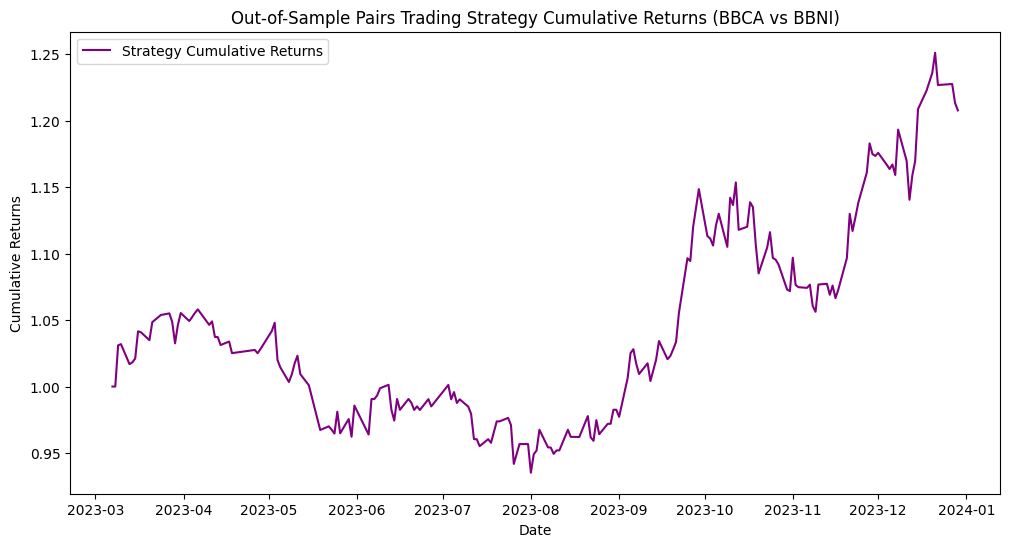

Cumulative Return (Testing Data): 20.78%
Sharpe Ratio (Testing Data): 1.28


<ipython-input-91-c85055708d2e>:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = test_data['Cumulative_Strategy_Returns'][-1] - 1


In [ ]:
# Step 1: Install Required Libraries (if not already installed)
!pip install yfinance statsmodels

# Step 2: Importing Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 3: Data Retrieval
# Define the stock symbols
symbols = ['BBCA.JK', 'BBNI.JK']

# Fetch data
data = yf.download(symbols, start='2020-01-01', end='2024-01-01')['Adj Close']
data.dropna(inplace=True)  # Drop any rows with NaN values

# Display the first few rows of data
print(data.head())

# Step 4: Split Data into Training and Testing Sets
train_size = int(len(data) * 0.8)  # Use 80% of the data for training
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Step 5: Cointegration Test on Training Data
def cointegration_test(stock1, stock2):
    score, p_value, _ = sm.tsa.coint(stock1, stock2)
    return p_value

# Perform the cointegration test
p_value = cointegration_test(train_data['BBCA.JK'], train_data['BBNI.JK'])
print(f'Cointegration test p-value for BBCA and BBNI: {p_value}')

# Step 6: Calculate the Spread on Training Data
model = sm.OLS(train_data['BBCA.JK'], sm.add_constant(train_data['BBNI.JK'])).fit()
train_data['Spread'] = train_data['BBCA.JK'] - model.predict(sm.add_constant(train_data['BBNI.JK']))

# Step 7: Implement the Trading Strategy on Training Data
# Define entry and exit thresholds
entry_threshold = 1  # 1 standard deviation
exit_threshold = 0.5  # 0.5 standard deviation

# Initialize signals and positions for training data
train_data['Signal'] = 0  # Default signal
train_data['Position'] = 0  # Default position

# Generate signals based on the spread for training data
train_data['Signal'][train_data['Spread'] > train_data['Spread'].mean() + entry_threshold * train_data['Spread'].std()] = -1  # Short
train_data['Signal'][train_data['Spread'] < train_data['Spread'].mean() - entry_threshold * train_data['Spread'].std()] = 1  # Long

# Forward fill signals to create positions for training data
train_data['Position'] = train_data['Signal'].replace(to_replace=0, method='ffill')

# Step 8: Apply Trading Signals to Testing Data
# Calculate the spread for testing data
test_data['Spread'] = test_data['BBCA.JK'] - (model.params[0] + model.params[1] * test_data['BBNI.JK'])

# Initialize signals and positions for testing data
test_data['Signal'] = 0  # Default signal
test_data['Position'] = 0  # Default position

# Generate signals based on the spread for testing data
test_data['Signal'][test_data['Spread'] > train_data['Spread'].mean() + entry_threshold * train_data['Spread'].std()] = -1  # Short
test_data['Signal'][test_data['Spread'] < train_data['Spread'].mean() - entry_threshold * train_data['Spread'].std()] = 1  # Long

# Forward fill signals to create positions for testing data
test_data['Position'] = test_data['Signal'].replace(to_replace=0, method='ffill')

# Calculate daily returns
test_data['BBCA_Return'] = test_data['BBCA.JK'].pct_change()
test_data['BBNI_Return'] = test_data['BBNI.JK'].pct_change()

# Calculate strategy returns for testing data
test_data['Strategy_Return'] = test_data['Position'].shift(1) * (test_data['BBCA_Return'] - test_data['BBNI_Return'])

# Cumulative returns for testing data
test_data['Cumulative_Strategy_Returns'] = (1 + test_data['Strategy_Return']).cumprod()

# Step 9: Plot Cumulative Returns for Testing Data
plt.figure(figsize=(12, 6))
plt.plot(test_data['Cumulative_Strategy_Returns'], label='Strategy Cumulative Returns', color='purple')
plt.title('Out-of-Sample Pairs Trading Strategy Cumulative Returns (BBCA vs BBNI)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Step 10: Evaluate Performance
# Performance metrics
cumulative_return = test_data['Cumulative_Strategy_Returns'][-1] - 1
sharpe_ratio = test_data['Strategy_Return'].mean() / test_data['Strategy_Return'].std() * np.sqrt(252)  # Annualized Sharpe Ratio

print(f'Cumulative Return (Testing Data): {cumulative_return:.2%}')
print(f'Sharpe Ratio (Testing Data): {sharpe_ratio:.2f}')
